# LRP 

### Disable Debugging Tensorflow

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Imports

In [2]:
import keras.applications.vgg16 as vgg16

import innvestigate

import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load Image

In [8]:
image_path = "data/tabby-cat.png"
image = cv2.imread(image_path)

resized_image = cv2.resize(image, [224,224])
image = resized_image

### Model

In [9]:
model= vgg16.VGG16(weights="imagenet")
preprocess = vgg16.preprocess_input
decode_predictions = vgg16.decode_predictions

### Helper Function

In [10]:
def predictions_model(image, model):
    x = preprocess(image[None])
    predictions = model.predict(x)
    decoded_predictions = decode_predictions(predictions, top=5)[0]
    return decoded_predictions[0]

In [14]:
rule_list = ["lrp.alpha_1_beta_0"]
num_rules = len(rule_list)

@tf.function
def analyze_and_plot_lrp(image, model):
    model = innvestigate.model_wo_softmax(model)
    
    fig, axes = plt.subplots(1, num_rules, figsize=(15, 3))
    
    for i, rule in enumerate(rule_list):
        analyzer = innvestigate.create_analyzer(rule, model)
        
        # Convert numpy array to a TensorFlow tensor
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        
        # Preprocess the image using TensorFlow operations
        image_processed = preprocess(tf.expand_dims(image_tensor, axis=0))
        
        a = analyzer.analyze(image_processed)
        
        # Sum along the axis with size 3
        a = tf.reduce_sum(a, axis=tf.argmax(tf.shape(a) == 3))
        a /= tf.reduce_max(tf.abs(a))
        
        ax = axes[i] if num_rules > 1 else axes
        ax.imshow(a.numpy()[0], cmap="seismic", clim=(-1, 1))
        ax.set_title(rule)
    
    plt.tight_layout()
    plt.show()

In [15]:
def plot_numpy_array(array,title=''):
    array = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)
    plt.imshow(array)
    plt.title(title)
    plt.savefig(title)
    plt.show()

### Use Analyzer and Plot

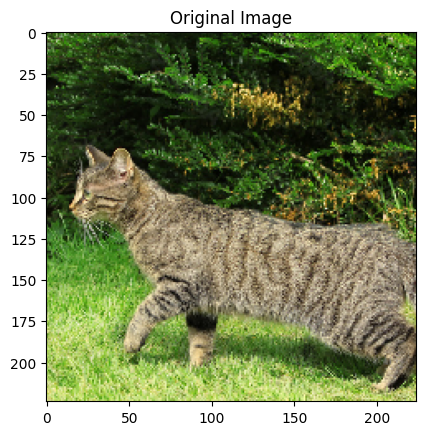

1/1 [==============================] - 0s 83ms/step


ValueError: in user code:

    File "C:\Users\timBo\AppData\Local\Temp\ipykernel_11032\929065137.py", line 14, in analyze_and_plot_lrp  *
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    ValueError: Tensor conversion requested dtype float32 for Tensor with dtype uint8: <tf.Tensor 'image:0' shape=(224, 224, 3) dtype=uint8>


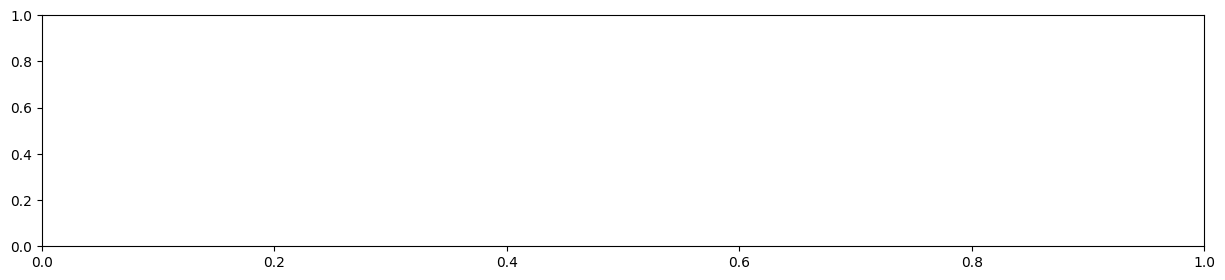

In [16]:
plot_numpy_array(image,"Original Image")
predictions_model(image,model)
analyze_and_plot_lrp(image,model)

## Add Noise

In [9]:
np.random.seed(50)
noise = np.random.normal(0, 25, image.shape) 
noise_image = image + noise
noise_image = np.clip(noise_image, 0, 255).astype(np.uint8)

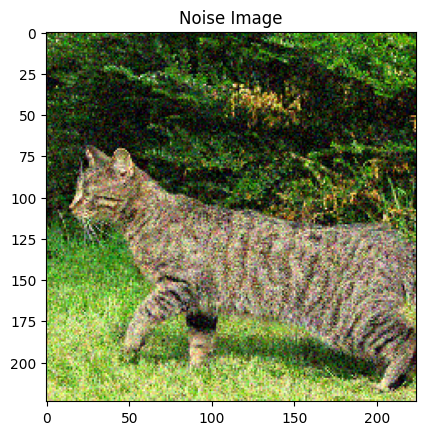

1: lynx (0.69)
2: Egyptian_cat (0.09)
3: tiger_cat (0.09)
4: African_crocodile (0.05)
5: coyote (0.04)


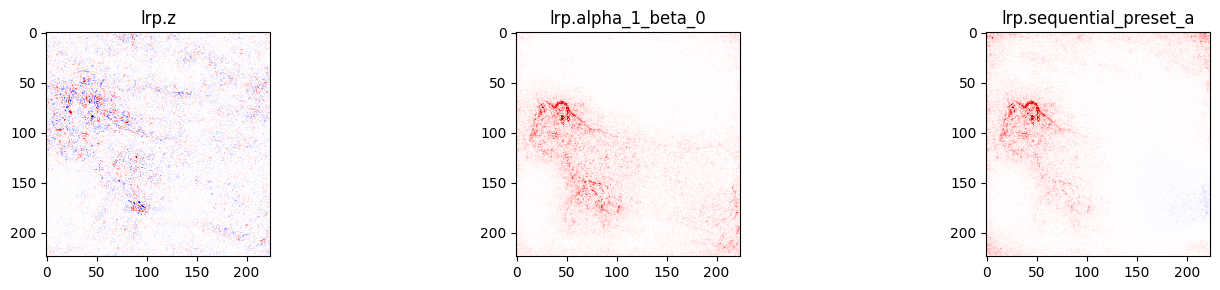

In [10]:
plot_numpy_array(noise_image,"Noise Image")
predictions_model(noise_image,model)
analyze_image_lrp(noise_image,model)

### Add Rotation

In [11]:
rotated_image = np.rot90(image)

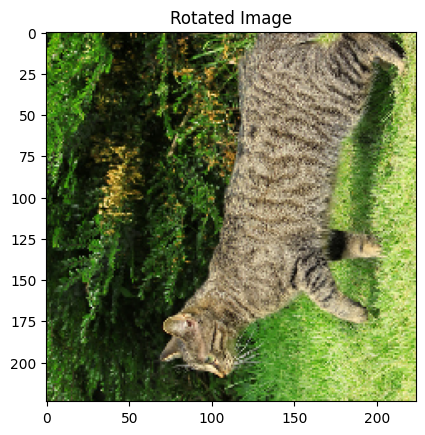

1: tiger_cat (0.73)
2: tabby (0.08)
3: Egyptian_cat (0.06)
4: lynx (0.05)
5: great_grey_owl (0.01)


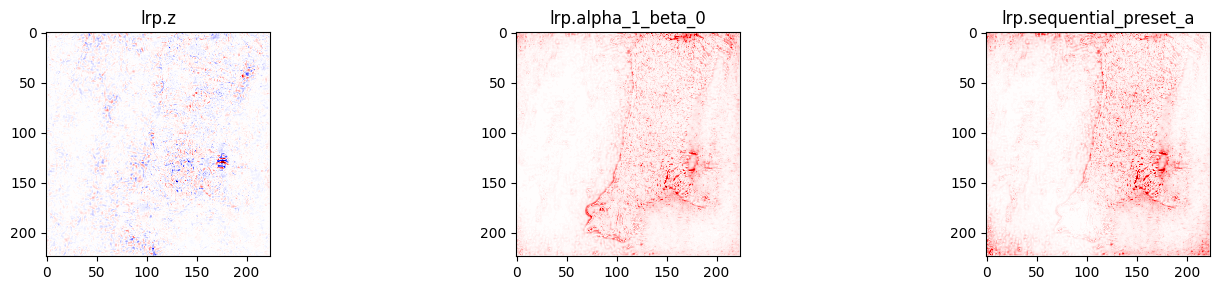

In [12]:
plot_numpy_array(rotated_image,"Rotated Image")
predictions_model(rotated_image,model)
analyze_image_lrp(rotated_image,model)

In [12]:
# analyzers: dict[str, type[AnalyzerBase]] = {
#     # Utility.
#     "input": Input,
#     "random": Random,
#     # Gradient based
#     "gradient": Gradient,
#     "gradient.baseline": BaselineGradient,
#     "input_t_gradient": InputTimesGradient,
#     "deconvnet": Deconvnet,
#     "guided_backprop": GuidedBackprop,
#     "integrated_gradients": IntegratedGradients,
#     "smoothgrad": SmoothGrad,
#     # Relevance based
#     "lrp": LRP,
#     "lrp.z": LRPZ,
#     "lrp.epsilon": LRPEpsilon,
#     "lrp.w_square": LRPWSquare,
#     "lrp.flat": LRPFlat,
#     "lrp.alpha_beta": LRPAlphaBeta,
#     "lrp.alpha_2_beta_1": LRPAlpha2Beta1,
#     "lrp.alpha_2_beta_1_IB": LRPAlpha2Beta1IgnoreBias,
#     "lrp.alpha_1_beta_0": LRPAlpha1Beta0,
#     "lrp.alpha_1_beta_0_IB": LRPAlpha1Beta0IgnoreBias,
#     "lrp.z_plus": LRPZPlus,
#     "lrp.z_plus_fast": LRPZPlusFast,
#     "lrp.sequential_preset_a": LRPSequentialPresetA,
#     "lrp.sequential_preset_b": LRPSequentialPresetB,
#     "lrp.sequential_preset_a_flat": LRPSequentialPresetAFlat,
#     "lrp.sequential_preset_b_flat": LRPSequentialPresetBFlat,
#     "lrp.sequential_preset_b_flat_until_idx": LRPSequentialPresetBFlatUntilIdx,
#     # Deep Taylor
#     "deep_taylor": DeepTaylor,
#     "deep_taylor.bounded": BoundedDeepTaylor,
# }